# Model Building

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re

## 1. XGBoost

In [31]:
dataset = pd.read_csv('/content/drive/MyDrive/ISDS 577- Capstone/US Accidents/Data/new_dataset.csv')
dataset.head()

,Distance(mi),State,Temperature(F),Humidity(%),Pressure(in),Wind_Direction,Wind_Speed(mph),Weather_Condition,Amenity,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Duration(min),Population,Severity
0,0.01,Ohio,36.0,100.0,29.67,SW,3.5,cloudy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,30.0,11664865.25,2.0
1,0.01,Ohio,35.1,96.0,29.64,SW,4.6,cloudy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,11664865.25,3.0
2,0.01,Ohio,36.0,89.0,29.65,SW,3.5,cloudy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,30.0,11664865.25,2.0
3,0.01,Ohio,37.9,97.0,29.63,S,3.5,rain,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,11664865.25,3.0
4,0.00,Ohio,34.0,100.0,29.66,W,3.5,cloudy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,11664865.25,2.0


## Encoding the Categorical Variables

In [32]:
df= dataset

In [33]:
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
# Assigning numerical values and storing in another column
df['Severity'] = label.fit_transform(df['Severity']) # Output/Dependent Variable
df['State'] = label.fit_transform(df['State'])
df['Wind_Direction'] = label.fit_transform(df['Wind_Direction'])
df['Weather_Condition'] = label.fit_transform(df['Weather_Condition'])
df.head()

,Distance(mi),State,Temperature(F),Humidity(%),Pressure(in),Wind_Direction,Wind_Speed(mph),Weather_Condition,Amenity,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Duration(min),Population,Severity
0,0.01,32,36.0,100.0,29.67,7,3.5,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,30.0,11664865.25,1
1,0.01,32,35.1,96.0,29.64,7,4.6,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,11664865.25,2
2,0.01,32,36.0,89.0,29.65,7,3.5,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,30.0,11664865.25,1
3,0.01,32,37.9,97.0,29.63,5,3.5,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,11664865.25,2
4,0.00,32,34.0,100.0,29.66,9,3.5,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,11664865.25,1


In [34]:
dataset= df

## Splitting the Dataset into Training and Testing set

In [35]:
X = dataset.iloc[:,:-1].values
Y = dataset.iloc[:,-1].values

In [36]:
print(X)

[[1.00000000e-02 3.20000000e+01 3.60000000e+01 ... 1.00000000e+00
  3.00000000e+01 1.16648652e+07]
 [1.00000000e-02 3.20000000e+01 3.51000000e+01 ... 0.00000000e+00
  3.00000000e+01 1.16648652e+07]
 [1.00000000e-02 3.20000000e+01 3.60000000e+01 ... 1.00000000e+00
  3.00000000e+01 1.16648652e+07]
 ...
 [0.00000000e+00 2.30000000e+01 7.40000000e+01 ... 0.00000000e+00
  2.70000000e+01 1.05569600e+06]
 [0.00000000e+00 2.30000000e+01 6.00000000e+01 ... 0.00000000e+00
  3.00000000e+01 1.05569600e+06]
 [0.00000000e+00 2.30000000e+01 7.90000000e+01 ... 0.00000000e+00
  2.90000000e+01 1.05569600e+06]]


In [37]:
print(Y)

[1 2 1 ... 1 1 1]


In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 10)
print('Training set Shape: {}  | Test set Shape: {}'.format(X_train.shape, X_test.shape))

Training set Shape: (2419328, 21)  | Test set Shape: (604832, 21)


Now we will check the distribution of classes in the outpit/dependent variable.

In [39]:
from collections import Counter
counter = Counter(Y_train)
print(counter)

Counter({1: 1644407, 2: 677243, 3: 75063, 0: 22615})


## Approach No. 1: Building XGBoost Model on a Balanced Data

In order to do so we neend to handle the imbalance in our data

### Handling Imbalance

Importing library required to handle imbalance problem

In [40]:
!pip install imblearn

Now we will peform random UnderSampling on Class 1, Class 2, Class 3.

Before random UnderSampling the count of each output category is:
1. 22615: Class 0 {Severity:1}
2. 1644407: Class 1 {Severity:2}
3. 677243: Class 2 {Severity:3}
4. 75063: Class 3 {Severity:4}

In [41]:
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler

under = RandomUnderSampler(sampling_strategy={0:22615,1:75000,2:75000,3:75000}, random_state=10)
under.fit(X_train, Y_train)
X_Under, Y_Under = under.fit_sample(X_train, Y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [42]:
from collections import Counter
counter = Counter(Y_Under)
print(counter)

Counter({1: 75000, 2: 75000, 3: 75000, 0: 22615})


### SMOTE

Now we will oversample the Class 0 by using SMOTE oversampling method.

Synthetic Minority Oversampling Technique (SMOTE) is a type of data augmentation for the minority class. SMOTE takes instance from the minority class (in our case Class 0) then k of the nearest neighbors of that instance are found (default k=5). A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space. 

In [43]:
from imblearn.over_sampling import SMOTE
sm = SMOTE("minority")
# The Resampled Data Frames will be: Y_train_res and X_train_res
X_train_res, Y_train_res = sm.fit_sample(X_Under, Y_Under)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [44]:
from collections import Counter
counter = Counter(Y_train_res)
print(counter)

Counter({0: 75000, 1: 75000, 2: 75000, 3: 75000})


### Building XGBoost model

In [ ]:
from xgboost import XGBClassifier
xg = XGBClassifier(n_estimators=100, max_depth=5)
model0= xg.fit(X_train_res, Y_train_res)

Import the packages necessary for evaluation 

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,precision_score,recall_score

In [ ]:
#Training Set Accuracy

Yt_pred = model0.predict(X_train_res)
train_acc= accuracy_score(Yt_pred,Y_train_res)
print('Training Accuracy using softmax = {}'.format(train_acc))

Training Accuracy using softmax = 0.7368433333333333


In [ ]:
# Testing Set Accuracy

Y_pred = model0.predict(X_test)
error_rate = np.sum(Y_pred != Y_test) / Y_test.shape[0]
test_acc= accuracy_score(Y_pred, Y_test)
print('Test set accuracy using softmax = {}'.format(test_acc))

Test set accuracy using softmax = 0.5739312734775938


In [ ]:
print ('Recall:', recall_score(Y_test, Y_pred, average='weighted'))
print ('Precision:', precision_score(Y_test, Y_pred, average='weighted'))

Recall: 0.5739312734775938
Precision: 0.7269140340907075


### Building Confusion Matrix

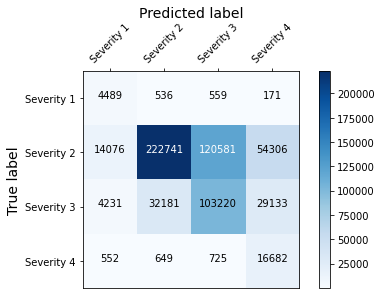

In [ ]:
matrix = confusion_matrix(Y_test,Y_pred)

plt.clf()

# place labels at the top
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')

# plot the matrix per se
plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)

# plot colorbar to the right
plt.colorbar()

fmt = 'd'

# write the number of predictions in each bucket
import itertools
thresh = matrix.max() / 2.
for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):

    # if background is dark, use a white number, and vice-versa
    plt.text(j, i, format(matrix[i, j], fmt),
         horizontalalignment="center",
         color="white" if matrix[i, j] > thresh else "black")

class_names = ['Severity 1','Severity 2','Severity 3','Severity 4']
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.tight_layout()
plt.ylabel('True label',size=14)
plt.xlabel('Predicted label',size=14)
plt.show()

The roc_auc_score always runs from 0 to 1, and is sorting predictive possibilities. 0.5 is the baseline for random guessing, so you want to always get above 0.5.

The roc_auc_score() of sklearn only works for binary classification. In our problem statement we are performing a multiclass classification hence, we will define a new function specifically for any multiclass classification problem.

In [ ]:
def multiclass_roc_auc_score(Y_test, Y_pred, average="macro"):
  from sklearn.metrics import roc_auc_score
  from sklearn.preprocessing import LabelBinarizer
  lb = LabelBinarizer()
  lb.fit(Y_test)
  Y_test = lb.transform(Y_test)
  Y_pred = lb.transform(Y_pred)


  return roc_auc_score(Y_test, Y_pred, average=average)

In [ ]:
multiclass_roc_auc_score(Y_test, Y_pred)

0.7753525582251002

## Approach No. 2: Building XGBoost Model by Tuning Hyper-parameters 

### Building XGBoost model

Randomized Search CV

In [45]:

from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 200, num = 11)] # No. of Trees for our XGBoost
max_depth = [int(x) for x in np.linspace(3, 11,5)] # Max levels for the trees in XGBoost
# Now we will create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth}
print(random_grid)

{'n_estimators': [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200], 'max_depth': [3, 5, 7, 9, 11]}


In [46]:
from xgboost import XGBClassifier
xg = XGBClassifier(n_estimators=100, max_depth=5)
model0= xg.fit(X_train_res, Y_train_res)


xg=XGBClassifier()
xg_randomcv=RandomizedSearchCV(estimator=xg,param_distributions=random_grid,cv=3,verbose=2,
                               random_state=10,n_jobs=-1)
### fit the randomized model
xg_randomcv.fit(X_train_res,Y_train_res)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 50.0min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='de

In [47]:
xg_randomcv.best_params_

{'max_depth': 11, 'n_estimators': 120}

In [48]:
xg_randomcv

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='de

In [51]:
best_random_grid=xg_randomcv.best_estimator_

In [52]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,precision_score,recall_score

In [63]:
Yt_pred=best_random_grid.predict(X_train)
print(confusion_matrix(Y_train,Yt_pred))
print("Training Accuracy Score {}".format(accuracy_score(Y_train,Yt_pred)))

[[ 20244    983   1209    179]
 [ 44721 957243 454592 187851]
 [ 13106 122664 445422  96051]
 [  1081   1556   2216  70210]]
Training Accuracy Score 0.6171626997248822


In [50]:
Y_pred=best_random_grid.predict(X_test)
print(confusion_matrix(Y_test,Y_pred))
print("Accuracy Score {}".format(accuracy_score(Y_test,Y_pred)))
print("Classification report: {}".format(classification_report(Y_test,Y_pred)))

[[  4925    344    353    133]
 [ 11311 238158 114637  47598]
 [  3410  31246 109526  24583]
 [   392    579    804  16833]]
Accuracy Score 0.610817549336014
Classification report:               precision    recall  f1-score   support

           0       0.25      0.86      0.38      5755
           1       0.88      0.58      0.70    411704
           2       0.49      0.65      0.56    168765
           3       0.19      0.90      0.31     18608

    accuracy                           0.61    604832
   macro avg       0.45      0.75      0.49    604832
weighted avg       0.74      0.61      0.64    604832



In [53]:
print ('Recall:', recall_score(Y_test, Y_pred, average='weighted'))
print ('Precision:', precision_score(Y_test, Y_pred, average='weighted'))

Recall: 0.610817549336014
Precision: 0.7434697896904636


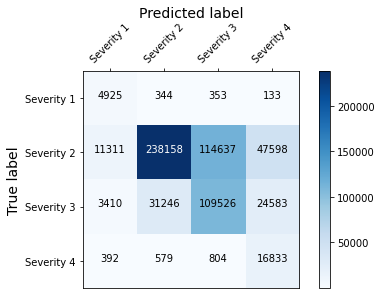

In [54]:
matrix = confusion_matrix(Y_test,Y_pred)

plt.clf()

# place labels at the top
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')

# plot the matrix per se
plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)

# plot colorbar to the right
plt.colorbar()

fmt = 'd'

# write the number of predictions in each bucket
import itertools
thresh = matrix.max() / 2.
for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):

    # if background is dark, use a white number, and vice-versa
    plt.text(j, i, format(matrix[i, j], fmt),
         horizontalalignment="center",
         color="white" if matrix[i, j] > thresh else "black")

class_names = ['Severity 1','Severity 2','Severity 3','Severity 4']
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.tight_layout()
plt.ylabel('True label',size=14)
plt.xlabel('Predicted label',size=14)
plt.show()

In [61]:
def multiclass_roc_auc_score(Y_test, Y_pred, average="macro"):
  from sklearn.metrics import roc_auc_score
  from sklearn.preprocessing import LabelBinarizer
  lb = LabelBinarizer()
  lb.fit(Y_test)
  Y_test = lb.transform(Y_test)
  Y_pred = lb.transform(Y_pred)

  return roc_auc_score(Y_test, Y_pred, average=average)

In [62]:
multiclass_roc_auc_score(Y_test, Y_pred)

0.8008937511748367

## Approach No. 3: Building XGBoost Model using parameter Weight Optimization

In [11]:
def CreateBalancedSampleWeights(T_train, largest_class_weight_coef):
    classes = np.unique(Y_train, axis = 0)
    classes.sort()
    class_samples = np.bincount(Y_train)
    total_samples = class_samples.sum()
    n_classes = len(class_samples)
    weights = total_samples / (n_classes * class_samples * 1.0)
    class_weight_dict = {key : value for (key, value) in zip(classes, weights)}
    class_weight_dict[classes[1]] = class_weight_dict[classes[1]] 
    largest_class_weight_coef
    sample_weights = [class_weight_dict[y] for y in Y_train]
    return sample_weights

Now we will define the model along with the weight which will be claculated by using the function defined above. 

In [12]:
from xgboost import XGBClassifier
    
largest_class_weight_coef = max(dataset['Severity'].value_counts().values)/dataset.shape[0]
    
# We will pass Y_train as numpy array
weight = CreateBalancedSampleWeights(Y_train, largest_class_weight_coef)

# And then use it like this
xg = XGBClassifier(n_estimators=150, weights = weight, max_depth=10)

In [13]:
model1= xg.fit(X_train, Y_train)

In [14]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,precision_score,recall_score

In [15]:
#Training Set Accuracy

Yt_pred = model1.predict(X_train)
train_acc= accuracy_score(Yt_pred,Y_train)
print('Training Accuracy using softmax = {}'.format(train_acc))

Training Accuracy using softmax = 0.7486587184540501


In [16]:
# Testing Set Accuracy

Y_pred = model1.predict(X_test)

test_acc= accuracy_score(Y_pred, Y_test)
print('Test set accuracy using softmax = {}'.format(test_acc))

Test set accuracy using softmax = 0.7396715120893075


In [17]:
print ('Recall:', recall_score(Y_test, Y_pred, average='weighted'))
print ('Precision:', precision_score(Y_test, Y_pred, average='weighted'))

Recall: 0.7396715120893075
Precision: 0.7227329600849733


Now we will plot the confusion matrix

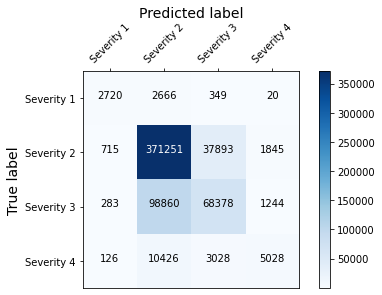

In [18]:
matrix = confusion_matrix(Y_test,Y_pred)

plt.clf()

# place labels at the top
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')

# plot the matrix per se
plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)

# plot colorbar to the right
plt.colorbar()

fmt = 'd'

# write the number of predictions in each bucket
import itertools
thresh = matrix.max() / 2.
for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):

    # if background is dark, use a white number, and vice-versa
    plt.text(j, i, format(matrix[i, j], fmt),
         horizontalalignment="center",
         color="white" if matrix[i, j] > thresh else "black")

class_names = ['Severity 1','Severity 2','Severity 3','Severity 4']
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.tight_layout()
plt.ylabel('True label',size=14)
plt.xlabel('Predicted label',size=14)
plt.show()

In [19]:
def multiclass_roc_auc_score(Y_test, Y_pred, average="macro"):
  from sklearn.metrics import roc_auc_score
  from sklearn.preprocessing import LabelBinarizer
  lb = LabelBinarizer()
  lb.fit(Y_test)
  Y_test = lb.transform(Y_test)
  Y_pred = lb.transform(Y_pred)


  return roc_auc_score(Y_test, Y_pred, average=average)

In [20]:
multiclass_roc_auc_score(Y_test, Y_pred)

0.6710311898682267